# Instalando Dependencias Necesarias

In [32]:
!py -m pip install --upgrade pip
!py -m pip install pandas numpy
!py -m pip install openpyxl
!py -m pip install numpy scipy matplotlib

# Punto 1.2 tomando de base los datos desarrollados en el archivo Taller1.xlsx

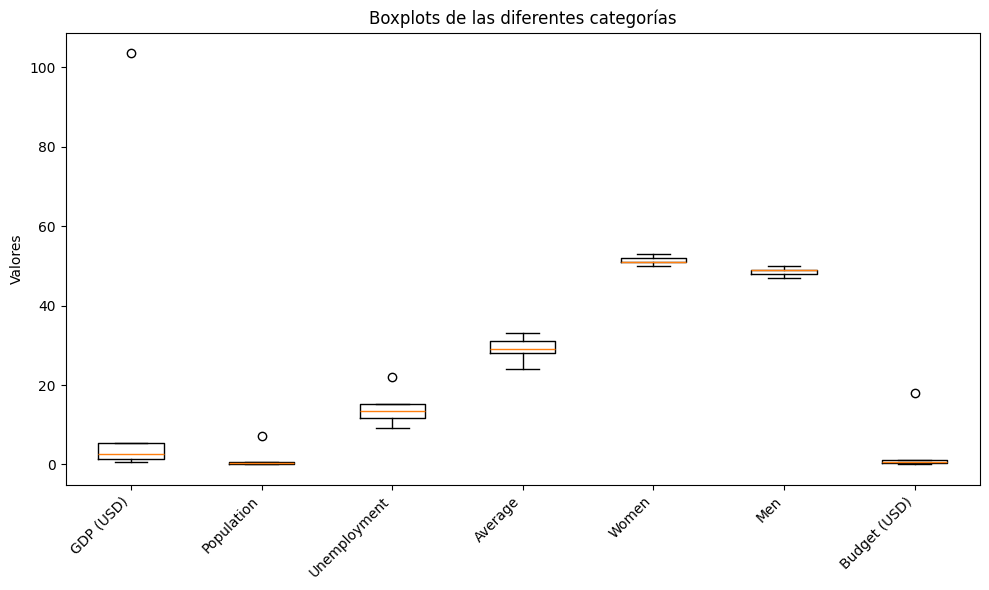

In [3]:
import matplotlib.pyplot as plt

# Datos de la segunda
data = {
    'GDP (USD)': [0.6, 1.275, 2.65, 5.375, 103.5],
    'Population': [0.01, 0.145, 0.39, 0.5425, 7.18],
    'Unemployment': [9.2, 11.575, 13.45, 15.325, 22],
    'Average': [24, 28, 29, 31, 33],
    'Women': [50, 51, 51, 52, 53],
    'Men': [47, 48, 49, 49, 50],
    'Budget (USD)': [0.05, 0.275, 0.6, 1.225, 18]
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(data.values())
ax.set_xticklabels(data.keys(), rotation=45, ha='right')

# Título y etiquetas
ax.set_title('Boxplots de las diferentes categorías')
ax.set_ylabel('Valores')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Graficando Individualmente

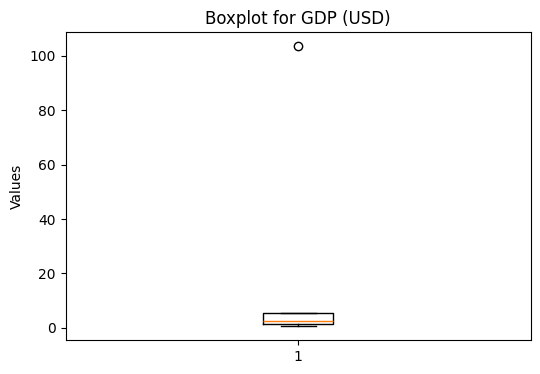

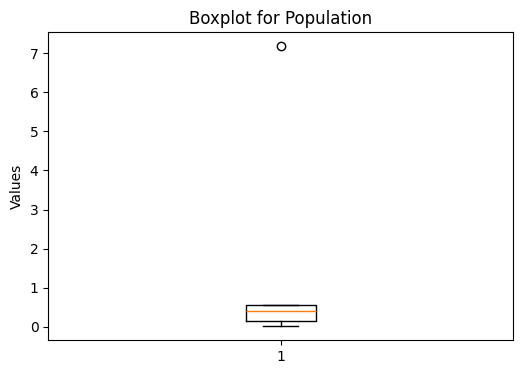

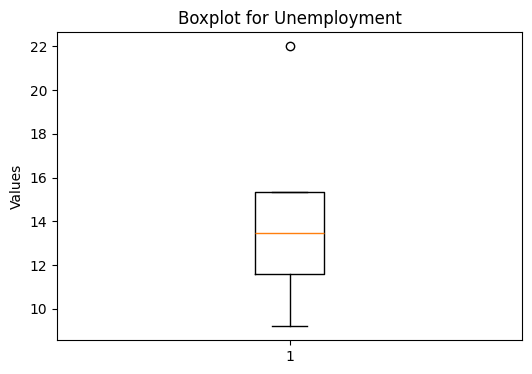

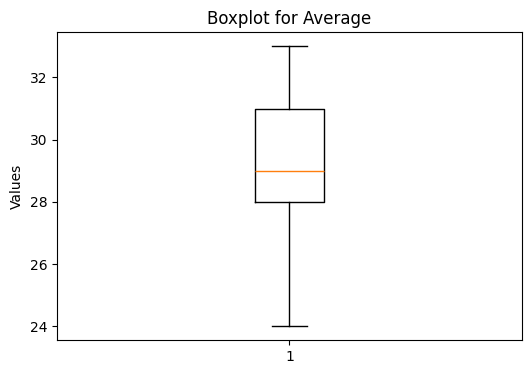

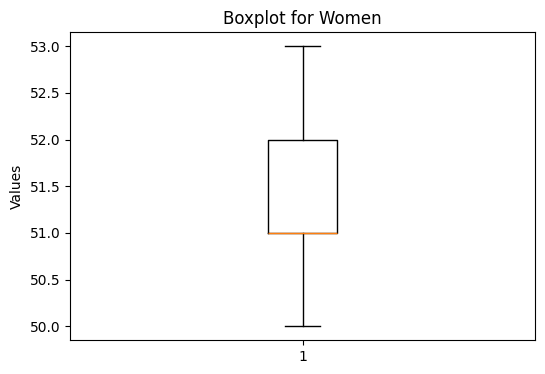

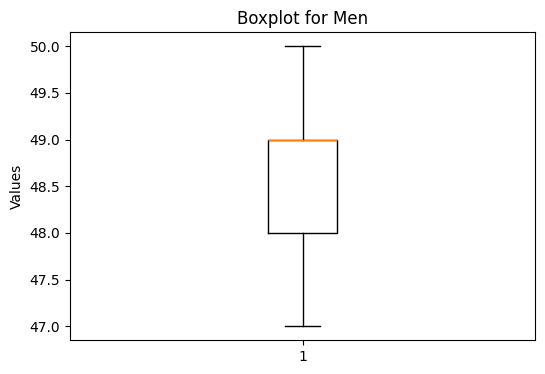

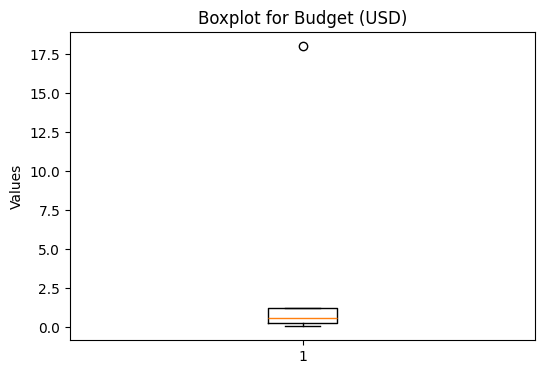

In [26]:
for category, values in data.items():
    plt.figure(figsize=(6, 4))
    plt.boxplot(values)
    
    # Formatear titulo con la etiquetas
    plt.title(f'Boxplot for {category}')
    plt.ylabel('Values')
    plt.show()

## Punto 1.6 Resultado de K Means para K=6 con los datos de entrenamiento

In [47]:
import pandas as pd
import numpy as np
import random
import math
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Paso 1: Leer los datos desde un archivo CSV
df = pd.read_csv('data/kmeans-cities/train.csv')

# Columnas numéricas que se usarán para K-Means
data = df[['GDP (USD Billion)', 'Population (Millions)', 'Unemployment Rate (%)', 'Average Age', 'Women (%)', 'Men (%)', 'Budget (USD Billion)']].values

# Paso 2: Inicializar centroides aleatoriamente (k=6 para 6 clusters)
def initializeCentroids(data, k):
    return random.sample(data.tolist(), k)

# Paso 3: Calcular la distancia euclidiana entre dos puntos
def euclideanDistance(point1, point2):
    return math.sqrt(sum([(p1 - p2) ** 2 for p1, p2 in zip(point1, point2)]))

# Paso 4: Asignar cada punto al centroide más cercano
def assignClusters(data, centroids):
    clusters = []
    distances = []  # Guardar las distancias para cada punto a cada centroide
    for point in data:
        distToCentroids = [euclideanDistance(point, centroid) for centroid in centroids]
        distances.append(distToCentroids)
        clusters.append(distToCentroids.index(min(distToCentroids)))  # El índice del centroide más cercano
    return clusters, distances

# Paso 5: Recalcular centroides
def updateCentroids(data, clusters, k):
    newCentroids = []
    for i in range(k):
        clusterPoints = [data[j] for j in range(len(data)) if clusters[j] == i]
        if clusterPoints:
            newCentroid = np.mean(clusterPoints, axis=0)
            newCentroids.append(newCentroid)
        else:
            newCentroids.append(random.choice(data))  # Si no hay puntos en un cluster, reasigna aleatoriamente
    return newCentroids

# Paso 6: Guardar resultados en una misma hoja Excel usando solo openpyxl
def saveResultsToExcel(df, centroids, distances, clusters, iteration, fileName='kmeans_resultado_final.xlsx'):
    # Guardar distancias en el DataFrame
    for i, centroid in enumerate(centroids):
        df[f'dis_C{i}'] = [dist[i] for dist in distances]
    
    # Guardar los clusters
    df['Cluster'] = clusters

    # Crear un DataFrame para los centroides
    centroidDf = pd.DataFrame(centroids, columns=df.columns[1:8])

    # Cargar o crear el archivo Excel
    try:
        book = load_workbook(fileName)  # Intenta cargar el archivo si ya existe
    except FileNotFoundError:
        book = Workbook()  # Si no existe, crea un nuevo libro de trabajo
        ws = book.active
        ws.title = "Resultados KMeans"
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        book = Workbook()
        ws = book.active
        ws.title = "Resultados KMeans"

    ws = book.active

    # Insertar el título de la iteración
    ws.append([f"Iteración {iteration}"])
    ws.append([])

    # Agregar la tabla de datos
    for row in dataframe_to_rows(df, index=False, header=True):
        ws.append(row)

    # Insertar un título para la tabla de centroides
    ws.append([f"Centroides Iteración {iteration}"])
    ws.append([])

    # Agregar la tabla de centroides
    for row in dataframe_to_rows(centroidDf, index=False, header=True):
        ws.append(row)
    
    # Guardar cambios
    book.save(fileName)
    book.close()

# Paso 7: Implementar el algoritmo K-Means
def kmeansWithExcel(data, df, k, maxIterations=100, fileName='kmeans_resultado_final.xlsx'):
    centroids = initializeCentroids(data, k)
    
    for iteration in range(maxIterations):
        clusters, distances = assignClusters(data, centroids)
        newCentroids = updateCentroids(data, clusters, k)
        
        # Guardar los resultados en un archivo Excel (una sola hoja)
        saveResultsToExcel(df.copy(), centroids, distances, clusters, iteration, fileName)
        
        # Verificar si los centroides cambiaron
        if np.allclose(centroids, newCentroids):
            print(f"Convergencia alcanzada en la iteración {iteration}")

            # Guardar los centroides finales en un archivo CSV
            centroid_df = pd.DataFrame(newCentroids, columns=df.columns[1:8])
            centroid_df.to_csv('centroides_finales.csv', index=False)
            print("Centroides finales guardados en 'centroides_finales.csv'.")
            break
        
        centroids = newCentroids

k = 6
kmeansWithExcel(data, df, k)

Convergencia alcanzada en la iteración 5
Centroides finales guardados en 'centroides_finales.csv'.


## Revisar Datos de Prueba Y Crear Archivo Resultante

In [51]:
import pandas as pd
import numpy as np
import math


# Función para normalizar los datos usando Min-Max normalization
def minMaxNormalization(data):
    normalized_data = []
    for feature in data.T:  # Transponemos para trabajar con cada columna (feature)
        min_value = min(feature)
        max_value = max(feature)
        normalized_feature = [(x - min_value) / (max_value - min_value) for x in feature]
        normalized_data.append(normalized_feature)
    return np.array(normalized_data).T 
    
# Paso 1: Cargar los centroides finales guardados en CSV
centroids = pd.read_csv('centroides_finales.csv').values

# Paso 2: Cargar los datos de prueba
dfTest = pd.read_csv('data/kmeans-cities/test.csv')

# Columnas numéricas que se usaron para K-Means
testData = dfTest[['GDP (USD Billion)', 'Population (Millions)', 'Unemployment Rate (%)', 
                     'Average Age', 'Women (%)', 'Men (%)', 'Budget (USD Billion)']].values

testDataNormalized = minMaxNormalization(testData)
centroidsNormalized = minMaxNormalization(centroids) 

# Paso 3: Definir la función para calcular la distancia euclidiana
def euclideanDistance(point1, point2):
    return math.sqrt(sum([(p1 - p2) ** 2 for p1, p2 in zip(point1, point2)]))

# Paso 4: Predecir la ciudad más cercana a cada punto de prueba
def predictClosestCentroid(testData, centroids, citys):
    predictions = []
    for city in testData:
        # Calcular la distancia de la ciudad de prueba a todos los centroides
        distances = [euclideanDistance(city, centroid) for centroid in centroids]
        
        # Encontrar el índice del centroide más cercano
        closestCentroidIdx = np.argmin(distances)
        
        # Obtener la ciudad correspondiente a ese centroide
        closestCity = citys[closestCentroidIdx]
        
        # Guardar la predicción
        predictions.append(closestCity)
    
    return predictions

citys = df['City'].values  #'City'  nombre de la columna correcta

# Hacer las predicciones para los datos de prueba
dfTest['label'] = predictClosestCentroid(testDataNormalized, centroidsNormalized, citys)
dfTest['ID'] = dfTest['City'] 

# Paso 5: Crear el archivo de envío en el formato requerido por Kaggle
dfSubmission = dfTest[['ID', 'label']]

# Guardar el archivo CSV para Kaggle
dfSubmission.to_csv('submission_kmeans.csv', index=False)

print("Archivo de envío creado exitosamente.")

Archivo de envío creado exitosamente.


## 1.7 Dendograma calculado usando la distancia máxima

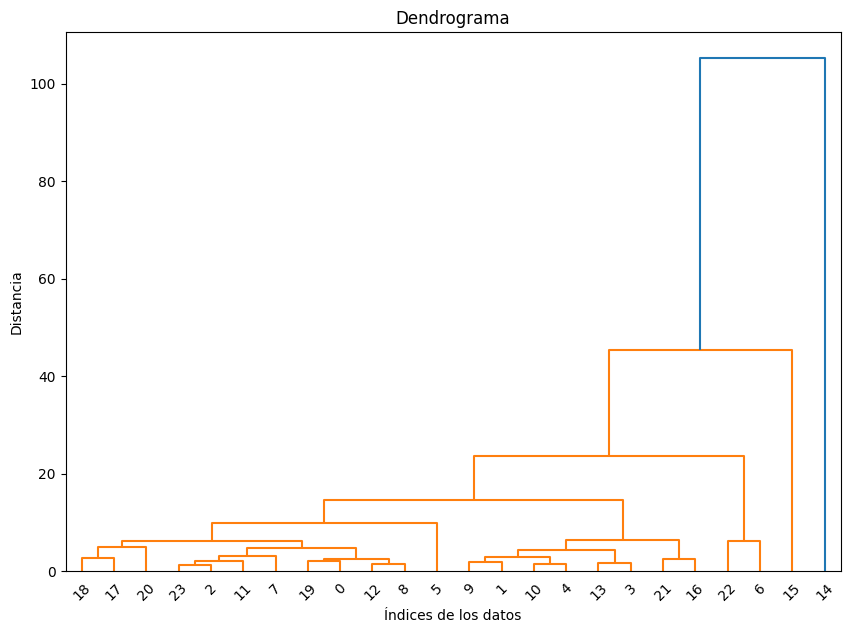

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Usando el mismo dataset
data = df[['GDP (USD Billion)', 'Population (Millions)', 'Unemployment Rate (%)', 'Average Age', 'Women (%)', 'Men (%)', 'Budget (USD Billion)']].values

# Calcular las distancias entre los puntos
distances = pdist(data)

# Aplicar clustering jerárquico con el método de enlace completo (distancia máxima)
linked = linkage(distances, method='complete')

# Crear el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

plt.title("Dendrograma")
plt.xlabel("Índices de los datos")
plt.ylabel("Distancia")
plt.show()

# Punto 2. PCA con GDP (USD Billion) y Population (Millions)

2.1. Matriz de Covarianza:
 [[396.58465517  26.68522414]
 [ 26.68522414   1.83015414]]
2.2. Eigenvalues (Valores propios):
 [3.44139937e-02 3.98380395e+02]
2.3. Varianza explicada por cada eigenvalue:
 [8.63772954e-05 9.99913623e-01]
2.4. Eigenvector (Vector propio) correspondiente al mayor eigenvalue:
 [-0.99774346 -0.06714158]
2.5. Matriz proyectada (Datos reducidos a 1D):
 [-94.96918871 -35.39370461 -13.71984343  -8.06533849  -1.76612638
   1.45686639   2.56109835   3.63981652   3.95458212   4.7534483
   4.95903973   5.25366286   5.55634298   5.75320601   5.95409753
   6.26147756   6.46236908   6.66393202   6.76504919   6.96661213
   7.06974356   7.26794942   7.47354085   7.57667228   7.67174671
   7.77823522   7.87599531   7.97845532   8.08024392   8.18001826]
2.6. Error entre la matriz proyectada y la original:
 [[-4.88678659e-03  7.26190790e-02]
 [ 3.61627519e-02 -5.37389078e-01]
 [-3.88840323e-02  5.77828101e-01]
 [ 2.86128484e-03 -4.25195301e-02]
 [-1.21410457e-02  1.80419493e-

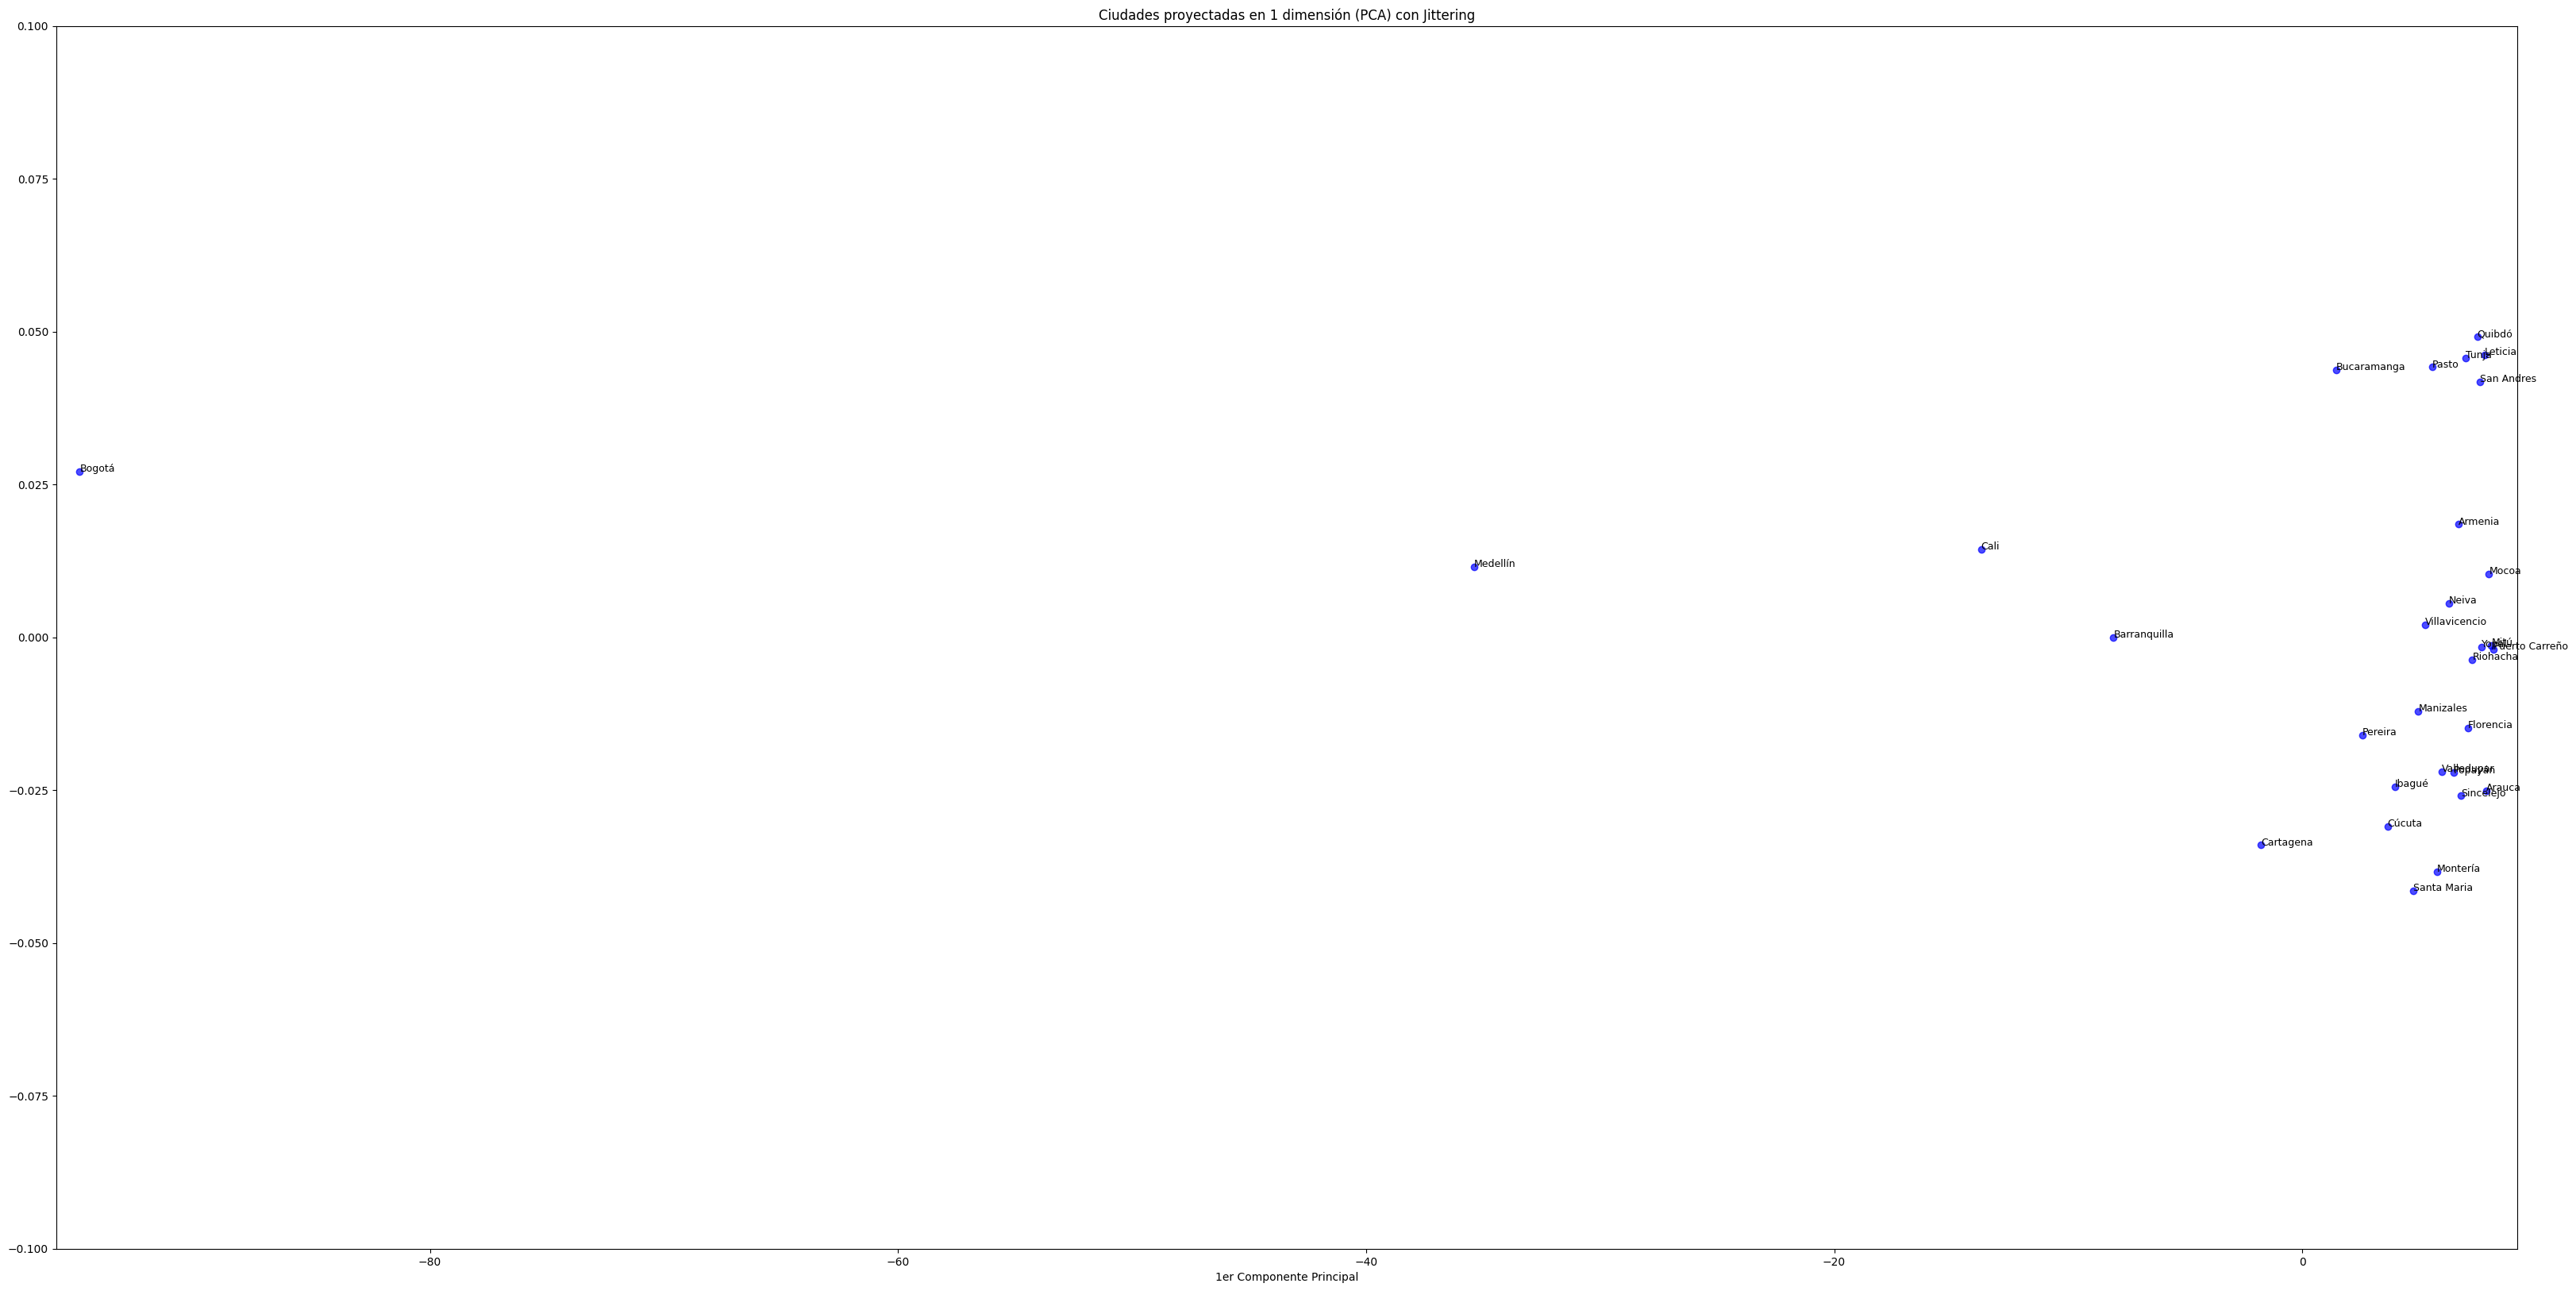

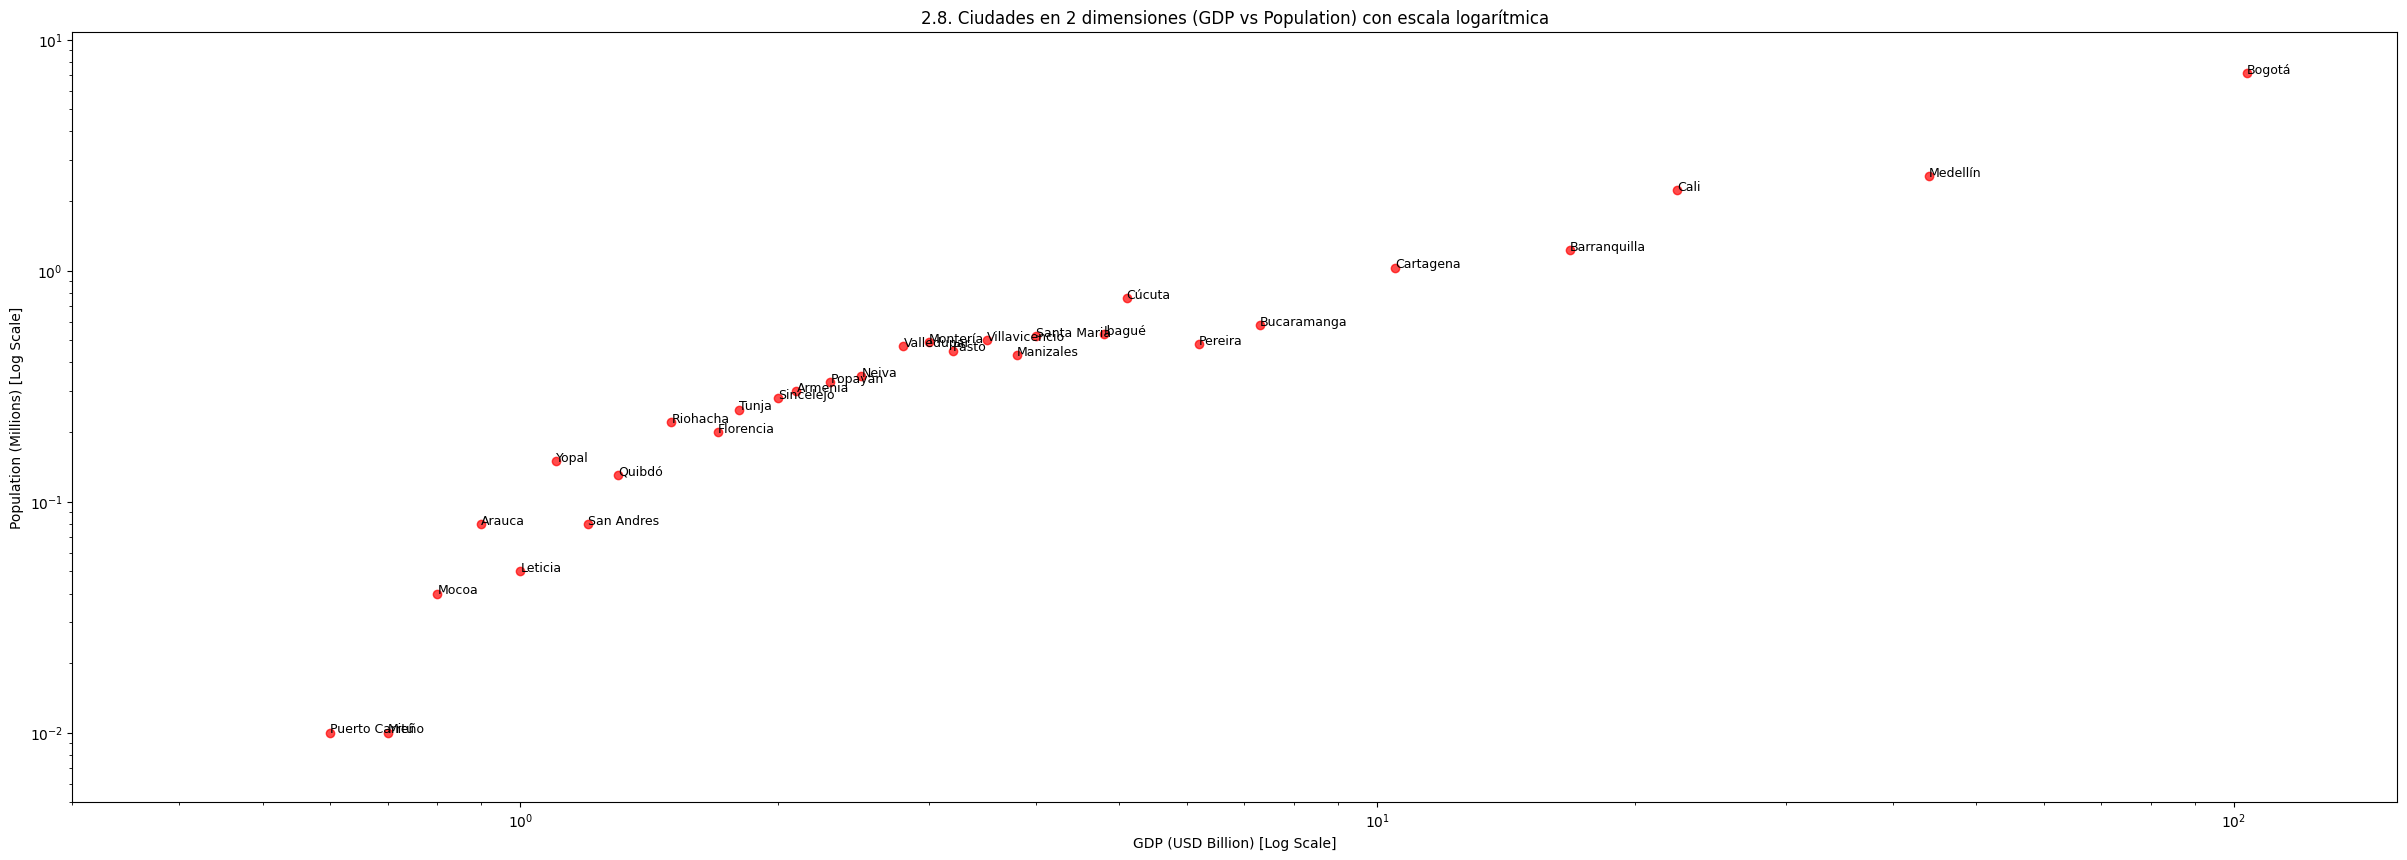

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'city': ['Bogotá', 'Medellín', 'Cali', 'Barranquilla', 'Cartagena', 'Bucaramanga', 'Pereira', 'Cúcuta', 'Ibagué',
             'Santa Maria', 'Manizales', 'Villavicencio', 'Pasto', 'Montería', 'Valledupar', 'Neiva', 'Popayán', 
             'Armenia', 'Sincelejo', 'Tunja', 'Florencia', 'Riohacha', 'Quibdó', 'San Andres', 'Yopal', 'Leticia', 
             'Arauca', 'Mocoa', 'Mitú', 'Puerto Carreño'],
    'gdpUsdBillion': [103.5, 44.1, 22.4, 16.8, 10.5, 7.3, 6.2, 5.1, 4.8, 4.0, 3.8, 3.5, 3.2, 3.0, 2.8, 2.5, 2.3, 
                      2.1, 2.0, 1.8, 1.7, 1.5, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6],
    'populationMillions': [7.18, 2.57, 2.23, 1.23, 1.03, 0.58, 0.48, 0.76, 0.53, 0.52, 0.43, 0.50, 0.45, 0.49, 0.47, 
                           0.35, 0.33, 0.30, 0.28, 0.25, 0.20, 0.22, 0.13, 0.08, 0.15, 0.05, 0.08, 0.04, 0.01, 0.01]
}
# Crear DataFrame
df = pd.DataFrame(data)

# Extraer variables para PCA
X = df[['gdpUsdBillion', 'populationMillions']].values

# Centrar los datos restando la media
XCentered = X - np.mean(X, axis=0)

# 2.1. Matriz de Covarianza
covMatrix = np.cov(XCentered, rowvar=False)
print("2.1. Matriz de Covarianza:\n", covMatrix)

# 2.2. Calcular Eigenvalues y Eigenvectors
eigenValues, eigenVectors = np.linalg.eigh(covMatrix)
print("2.2. Eigenvalues (Valores propios):\n", eigenValues)

# 2.3. Calcular la varianza explicada por cada Eigenvalue
explainedVariance = eigenValues / np.sum(eigenValues)
print("2.3. Varianza explicada por cada eigenvalue:\n", explainedVariance)

# 2.4. Eigenvector correspondiente al mayor Eigenvalue
principalEigenvector = eigenVectors[:, np.argmax(eigenValues)]
print("2.4. Eigenvector (Vector propio) correspondiente al mayor eigenvalue:\n", principalEigenvector)

# 2.5. Proyectar los datos a 1 dimensión utilizando el primer Eigenvector
XProjected = np.dot(XCentered, principalEigenvector)
print("2.5. Matriz proyectada (Datos reducidos a 1D):\n", XProjected)

# 2.6. Error entre la matriz proyectada y la original
XReconstructed = np.outer(XProjected, principalEigenvector) + np.mean(X, axis=0)
error = X - XReconstructed
print("2.6. Error entre la matriz proyectada y la original:\n", error)
print("Error medio por columna:\n", np.mean(np.abs(error), axis=0))

# 2.7. Graficar las ciudades proyectadas en 1 dimensión con Jittering
jitter = np.random.uniform(-0.05, 0.05, size=XProjected.shape)  # Pequeño desplazamiento vertical aleatorio
plt.figure(figsize=(40, 20))
plt.scatter(XProjected, jitter, alpha=0.7, color='blue')

# Agregar etiquetas a los puntos con jitter
for i, city in enumerate(df['city']):
    plt.text(XProjected[i], jitter[i], city, fontsize=9)

# Ajustar límites para ampliar la separación entre los puntos
plt.xlim(XProjected.min() - 1, XProjected.max() + 1)
plt.ylim(-0.1, 0.1)  # Limitar el eje Y para que los puntos queden alineados, pero con jitter
plt.title('Ciudades proyectadas en 1 dimensión (PCA) con Jittering')
plt.xlabel('1er Componente Principal')
plt.show()

# 2.8. Graficar las ciudades en las 2 dimensiones originales con escala logarítmica y ajustes en los límites
plt.figure(figsize=(30,10))
# Aplicar escala logarítmica en ambos ejes
plt.xscale('log')
plt.yscale('log')

# Graficar los puntos
plt.scatter(X[:, 0], X[:, 1], alpha=0.7, color='red')

# Añadir etiquetas a las ciudades
for i, city in enumerate(df['city']):
    plt.text(X[i, 0], X[i, 1], city, fontsize=9)
    
plt.title('2.8. Ciudades en 2 dimensiones (GDP vs Population) con escala logarítmica')
plt.xlabel('GDP (USD Billion) [Log Scale]')
plt.ylabel('Population (Millions) [Log Scale]')

# Ajustar límites
plt.xlim(X[:, 0].min() * 0.5, X[:, 0].max() * 1.5)
plt.ylim(X[:, 1].min() * 0.5, X[:, 1].max() * 1.5)
plt.show()